In [333]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
import statsmodels.api as sm

from datetime import datetime

### Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.
Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [334]:
# считываем датасет
data = pd.read_csv("data/ghana_gdp.csv",parse_dates=['year'], index_col=['year'])
data.head() 

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


<AxesSubplot:xlabel='year'>

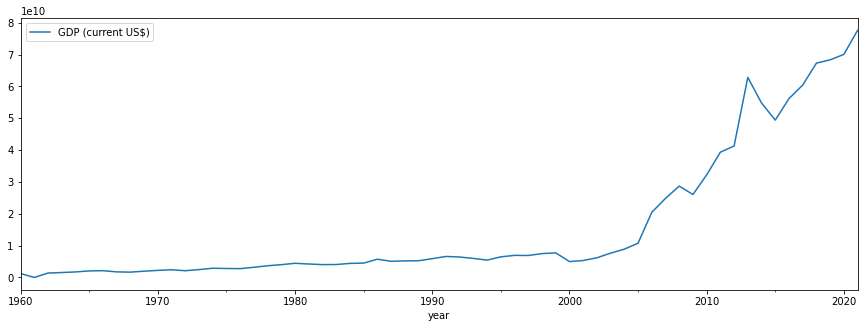

In [335]:
# визуализируем исходный временной ряд
plt.rcParams["figure.figsize"] = 15, 5
data.plot()

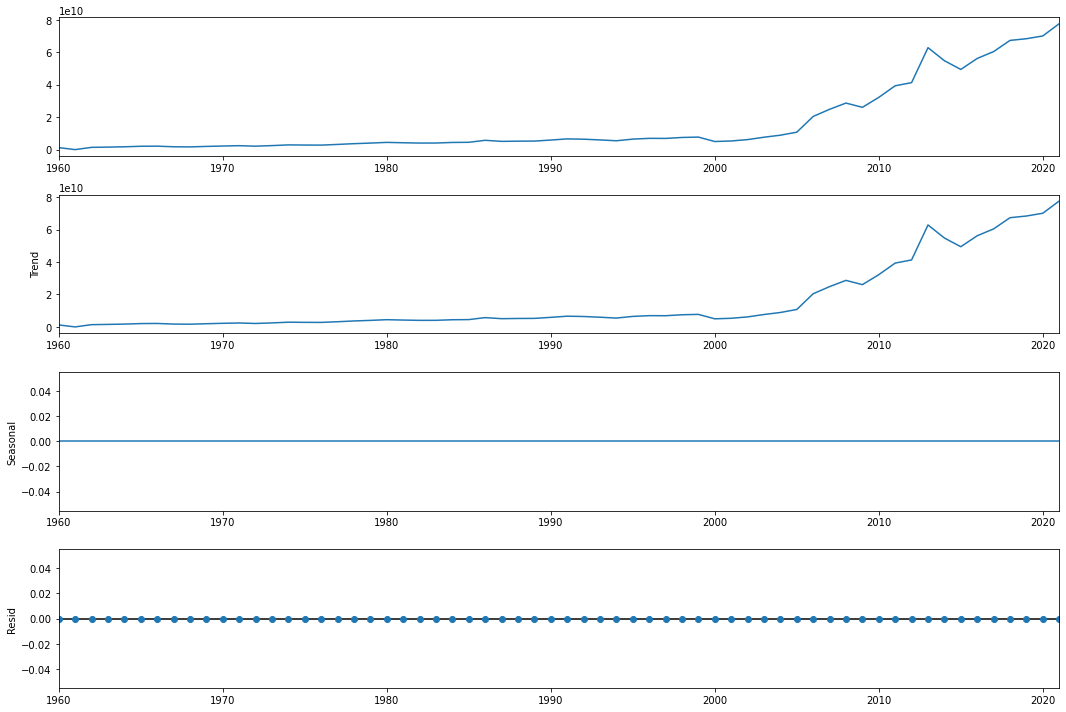

In [336]:
plt.rcParams["figure.figsize"] = 15, 10

result = seasonal_decompose(data)
result.plot()
plt.show()

*/ Вывод: В наличии тренд (рост), сезонность и шум отсутствуют, так как выборка небольшая и редкая (одно значение в год). /*

In [337]:
# Отложим последние три года из датасета как тестовую выборку для оценки результатов предсказания.
test_df = data.iloc[-4:-1]
train_df = data.iloc[:-4]

### 2. Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно. 

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

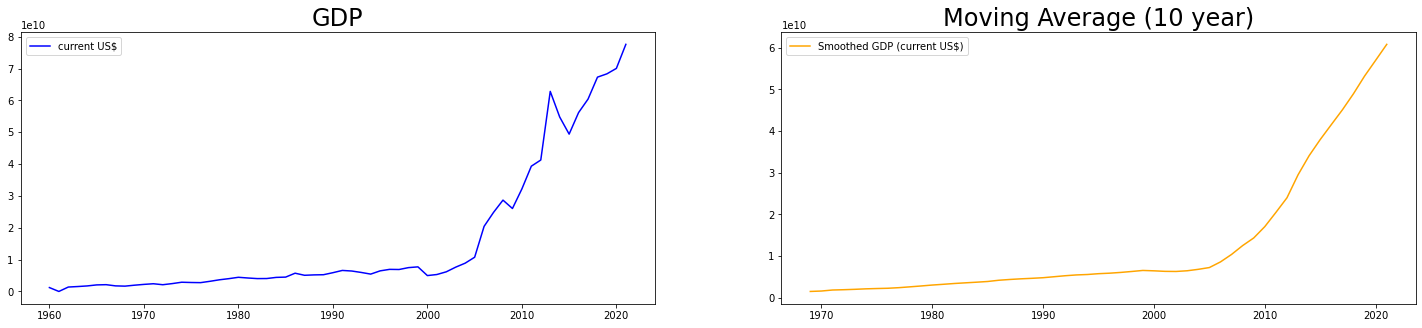

In [338]:
plt.rcParams["figure.figsize"] = 25, 5

fig, ax = plt.subplots(1, 2)

# Окно выбираем в декаду (Window = 10)
ax[0].plot(data, color="blue", label="current US$")
ax[0].set_title("GDP", size=24)
ax[0].legend()

ax[1].plot(
    data.rolling(window=10).mean(),
    color="orange",
    label="Smoothed GDP (current US$)",
)

ax[1].set_title("Moving Average (10 year)", size=24)
ax[1].legend()

plt.show()

*/ Вывод: Сглаживание позволяет более наглядно выделить общий тренд /*

### 3. С помощью теста Дики-Фуллера оценить стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA. 

In [339]:
from statsmodels.tsa.stattools import adfuller

In [340]:
# задаем функцию проверки на стационарность ряда и проверяем исходный ряд
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df)

adf:  0.5393306248349177
p-value:  0.9860207453998459
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


*/ Вывод: Ряд нестационарен, необходимо применить дифференцирование /*

In [341]:
# дифференцируем ряд и проверяем на стационарность
data_diff = train_df.diff().dropna()
stat_test(data_diff)

adf:  -0.7957779955549791
p-value:  0.8203591046306415
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


In [342]:
# ещё раз дифференцируем ряд и проверяем на стационарность
data_diff = data_diff.diff().dropna()
stat_test(data_diff)

adf:  -2.6938797070150144
p-value:  0.07510334813233245
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


In [343]:
# третий раз дифференцируем ряд и проверяем на стационарность
data_diff = data_diff.diff().dropna()
stat_test(data_diff)

adf:  -13.428793452586433
p-value:  4.0521041077229072e-25
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
единичных корней нет, ряд стационарен


*/ Вывод: исходный временной ряд является интегрированным рядом 3-го порядка. Необходимо использовать модель ARIMA /*

In [344]:
d=3

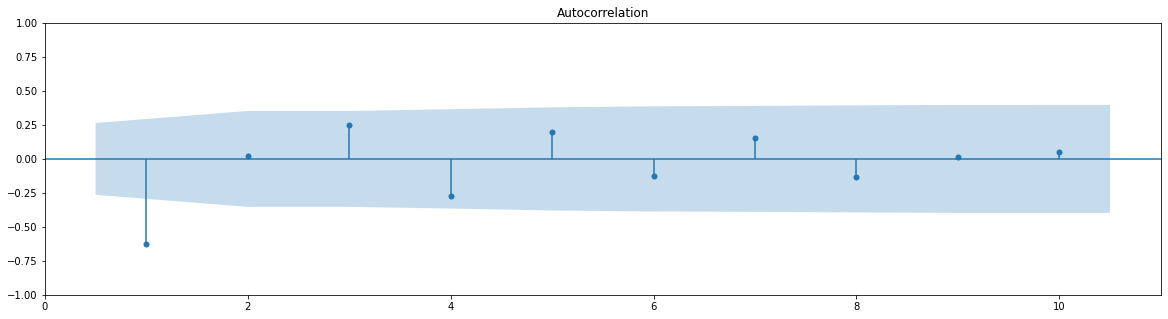

In [345]:
# Параметры p и q определяем по коррелограммам ACF и PACF
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(data_diff, lags=10, zero=False)
plt.show()

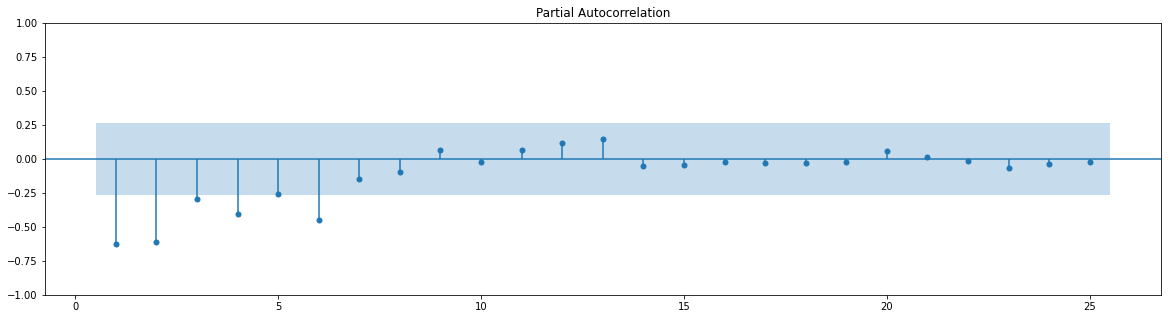

In [346]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(data_diff, lags=25, zero=False, method="ywm")
plt.show()

In [347]:
q=1
p=6

### Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

In [348]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df, order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

d:\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
d:\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
d:\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
d:\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   58
Model:                 ARIMA(6, 3, 1)   Log Likelihood               -1282.625
Date:                Tue, 12 Sep 2023   AIC                           2581.250
Time:                        10:58:18   BIC                           2597.309
Sample:                    01-01-1960   HQIC                          2587.460
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1486      0.077    -14.994      0.000      -1.299      -0.998
ar.L2         -1.3921      0.166     -8.398      0.000      -1.717      -1.067
ar.L3         -1.2894      0.226     -5.706      0.000      -1.732      -0.847
ar.L4         -1.4989      0.172     -8.736      0.000      -1.835      -1.163
ar.L5         -0.9290      0.167     -5.573      0.000      -1.256      -0.602
ar.L6         -0.7276      0.141     -5.146      0.000      -1.005      -0.450
ma.L1         -0.9080      0.055    -16.421      0.000      -1.016      -0.800
sigma2      8.184e+18   4.57e-20   1.79e+38      0.000    8.18e+18    8.18e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                51.47
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):              70.78   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.5e+54. Standard errors may be unstable.
"""

In [349]:
# выбираем наилучшие параметры с помощью пакета pmdarima
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=3,
    max_q=3,
    seasonal=False,
    test="adf",
    error_action="ignore",
    trace=True
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2619.511, Time=0.05 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2686.859, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2659.570, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2610.423, Time=0.04 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2631.764, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2610.925, Time=0.05 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2627.500, Time=0.03 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2612.413, Time=0.06 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.712 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1301.212
Date:                Tue, 12 Sep 2023   AIC                           2610.423
Time:                        10:58:18   BIC                           2618.453
Sample:                    01-01-1960   HQIC                          2613.528
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7622      0.129     -5.905      0.000      -1.015      -0.509
ar.L2         -0.5164      0.240     -2.149      0.032      -0.987      -0.045
ma.L1         -0.9743      0.106     -9.193      0.000      -1.182      -0.767
sigma2      3.044e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):               175.50
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):             407.41   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.7e+55. Standard errors may be unstable.
"""

*/ Вывод: перебор по сетке методом pmdarima показал, что параметры выбраны верно /*

### Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

In [350]:
# обучаем модель ARIMA и делаем предсказание для последних трёх позиций
arima_model = ARIMA(train_df, order=(p, d, q))
arima_model_fit = arima_model.fit()

ar_pred = arima_model_fit.predict(start=len(train_df), end=(len(train_df)+2), dynamic=False)
ar_pred

d:\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
d:\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
d:\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
d:\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. 

2018-01-01    7.825334e+10
2019-01-01    7.867814e+10
2020-01-01    8.541044e+10
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [351]:
# заглянем на 10 лет в будущее
ar_pred = arima_model_fit.predict(start=60, end=70, dynamic=False)
ar_pred

2020-01-01    8.541044e+10
2021-01-01    8.329185e+10
2022-01-01    7.926168e+10
2023-01-01    9.804434e+10
2024-01-01    1.026521e+11
2025-01-01    1.154556e+11
2026-01-01    1.167847e+11
2027-01-01    1.133058e+11
2028-01-01    1.233221e+11
2029-01-01    1.247344e+11
2030-01-01    1.444645e+11
Freq: AS-JAN, Name: predicted_mean, dtype: float64

### Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

In [352]:
# собираем в датасет данные для визуализации
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df["GDP (current US$)"] = data["GDP (current US$)"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

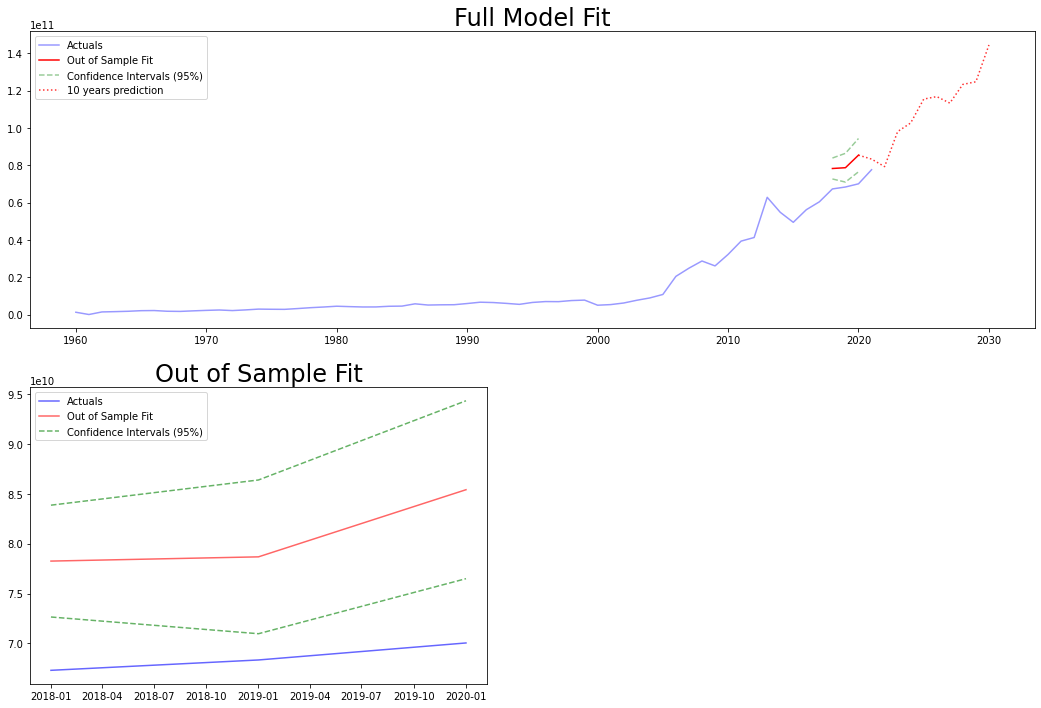

In [353]:
# строим графики истинного и предсказанного поведения временного ряда
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.plot(
    ar_pred,
    color="red",
    linestyle='dotted',
    alpha=0.8,
    label="10 years prediction",
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

*/ Вывод: модель уловила общий тренд. Предсказания близки к актуальным данным /*

# Интерполяция и сэмплирование

In [354]:
# Проверка данных на наличие пропущенных дат
df = data
df.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [355]:
# Проверка данных на наличие пропущенных значений
df.isna().sum()

GDP (current US$)    0
dtype: int64

In [356]:
# замена нулевых значений на NaN
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [357]:
# интерполируем пропущенные значения
df = df['GDP (current US$)'].interpolate(method='linear')
df.isna().sum()

0

In [358]:
# Отложим последние три года из датасета как тестовую выборку для оценки результатов предсказания.
test_df = df.iloc[-4:-1]
train_df = df.iloc[:-4]

In [359]:
# проверка на стационарность
stat_test(train_df)

adf:  0.49636386509276004
p-value:  0.9847621588942816
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


In [360]:
# дифференцируем ряд и проверяем на стационарность
data_diff = train_df.diff().dropna()
stat_test(data_diff)

adf:  -0.9407938408721084
p-value:  0.774241854662356
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


In [361]:
# 2-е дифференцирование ряда и проверка на стационарность
data_diff = data_diff.diff().dropna()
stat_test(data_diff)

adf:  -2.61937543654548
p-value:  0.08905851327688624
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


In [362]:
# 3-е дифференцирование ряда и проверка на стационарность
data_diff = data_diff.diff().dropna()
stat_test(data_diff)

adf:  -13.852530207137757
p-value:  6.962495232668243e-26
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
единичных корней нет, ряд стационарен


In [363]:
# выбираем наилучшие параметры с помощью пакета pmdarima
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=2,
    max_q=2,
    seasonal=False,
    test="adf",
    error_action="ignore",
    trace=True
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2619.511, Time=0.05 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2686.684, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2659.533, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2610.414, Time=0.05 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2631.712, Time=0.02 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec


 ARIMA(1,3,2)(0,0,0)[0]             : AIC=2598.921, Time=0.11 sec
 ARIMA(0,3,2)(0,0,0)[0]             : AIC=2616.047, Time=0.07 sec
 ARIMA(1,3,2)(0,0,0)[0] intercept   : AIC=2610.287, Time=0.06 sec

Best model:  ARIMA(1,3,2)(0,0,0)[0]          
Total fit time: 0.574 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(1, 3, 2)   Log Likelihood               -1295.461
Date:                Tue, 12 Sep 2023   AIC                           2598.921
Time:                        10:58:20   BIC                           2606.950
Sample:                    01-01-1960   HQIC                          2602.026
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1599      0.205     -0.780      0.435      -0.562       0.242
ma.L1         -1.8725      0.298     -6.279      0.000      -2.457      -1.288
ma.L2          0.8864      0.344      2.580      0.010       0.213       1.560
sigma2      2.238e+19   8.81e-21   2.54e+39      0.000    2.24e+19    2.24e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               224.21
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             521.71   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.47e+55. Standard errors may be unstable.
"""

*/ Вывод: набор оптимальных параметров изменился после интерполяции /*

In [364]:
# устанавливаем новые параметры модели и запускаем модель
p=1
d=3
q=2
arima_model = ARIMA(train_df, order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

d:\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
d:\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
d:\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
d:\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   58
Model:                 ARIMA(1, 3, 2)   Log Likelihood               -1295.461
Date:                Tue, 12 Sep 2023   AIC                           2598.921
Time:                        10:58:20   BIC                           2606.950
Sample:                    01-01-1960   HQIC                          2602.026
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1599      0.205     -0.780      0.435      -0.562       0.242
ma.L1         -1.8725      0.298     -6.279      0.000      -2.457      -1.288
ma.L2          0.8864      0.344      2.580      0.010       0.213       1.560
sigma2      2.238e+19   8.81e-21   2.54e+39      0.000    2.24e+19    2.24e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               224.21
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             521.71   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.47e+55. Standard errors may be unstable.
"""

*/ Вывод: Критерий AIC уменьшился. Модель стала точнее /*

# Валидация временных рядов

In [365]:
from sklearn.model_selection import TimeSeriesSplit

In [366]:
tscv = TimeSeriesSplit()
TimeSeriesSplit(n_splits=3, test_size=7)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=7)

In [367]:
train_test_groups = tscv.split(data) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 12 TEST size: 10
TRAIN size: 22 TEST size: 10
TRAIN size: 32 TEST size: 10
TRAIN size: 42 TEST size: 10
TRAIN size: 52 TEST size: 10


# Волатильность

In [368]:
# посчитаем волатильность ряда и отобразим график
data_vol = pd.DataFrame(df.pct_change(1).mul(100).abs())
data_vol.rename(columns={'GDP (current US$)':'vol'}, inplace=True)
data_vol.head()

,vol
year,
1960-01-01,NaN
1961-01-01,6.789413
1962-01-01,6.357759
1963-01-01,11.448835
1964-01-01,12.363636


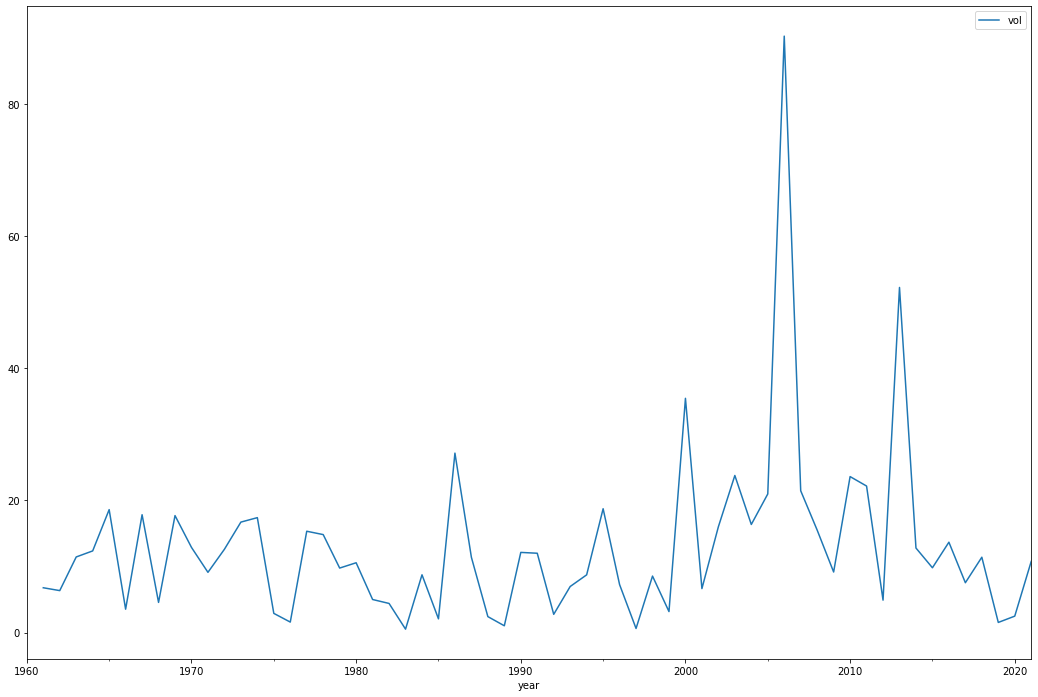

In [369]:
data_vol.plot()
plt.show()

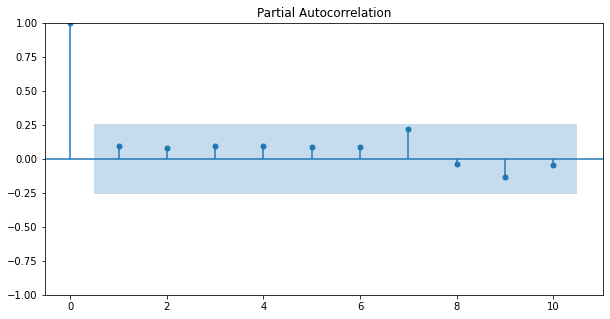

In [370]:
# разбиваем ряд значений волатильности на тренировочную и тестовую и построим график частичной автокорреляции
test_df_vol = data_vol.iloc[-4:-1]
train_df_vol = data_vol.iloc[:-4]
plt.rcParams["figure.figsize"] = 10, 5
sgt.plot_pacf(train_df_vol[1:], lags=10, method="ywm")
plt.show()

Вывод: слабая автокорреляция с лагом = 7

In [371]:
# проверим ряд на стационарность
adfuller(data_vol[1:])

(-6.807338944696351,
 2.1599127900854784e-09,
 0,
 60,
 {'1%': -3.5443688564814813,
  '5%': -2.9110731481481484,
  '10%': -2.5931902777777776},
 405.49789315481553)

Вывод: ряд стационарен

In [372]:
# строим модель для предсказания волатильности
from arch import arch_model
model = arch_model(data_vol.dropna(), p=6, q=1, vol = 'GARCH')
model_results = model.fit(last_obs=test_df_vol.index[0], update_freq=5)

Iteration:      5,   Func. Count:     55,   Neg. LLF: 213.50791273683092
Iteration:     10,   Func. Count:    108,   Neg. LLF: 220.2443598946739
Iteration:     15,   Func. Count:    159,   Neg. LLF: 211.51745568805933
Iteration:     20,   Func. Count:    210,   Neg. LLF: 211.20336548350065
Optimization terminated successfully    (Exit mode 0)
            Current function value: 211.20266717601788
            Iterations: 24
            Function evaluations: 249
            Gradient evaluations: 24


In [373]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -211.203
Distribution:                  Normal   AIC:                           440.405
Method:            Maximum Likelihood   BIC:                           458.793
                                        No. Observations:                   57
Date:                Tue, Sep 12 2023   Df Residuals:                       56
Time:                        10:58:20   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8528      1.297      9.140  6.268e-20 [  9.311, 14.395]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         41.5542     13.402      3.101  1.931e-03      [ 15.288, 67.821]
alpha[1]       0.0000  1.038e-02      0.000      1.000 [-2.035e-02,2.035e-02]
alpha[2]       0.0000  1.377e-02      0.000      1.000 [-2.698e-02,2.698e-02]
alpha[3]       0.0000  3.010e-02      0.000      1.000 [-5.899e-02,5.899e-02]
alpha[4]   3.8430e-03  5.138e-03      0.748      0.454 [-6.227e-03,1.391e-02]
alpha[5]   1.9351e-12  7.927e-03  2.441e-10      1.000 [-1.554e-02,1.554e-02]
alpha[6]       0.7842      0.495      1.583      0.113      [ -0.187,  1.755]
beta[1]        0.0897  6.575e-02      1.365      0.172   [-3.913e-02,  0.219]
=============================================================================

Covariance estimator: robust
"""

In [374]:
# делаем предсказание для последних трех значений
predictions_df = test_df_vol.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df_vol.index
]

d:\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [375]:
predictions_df

,vol,Predictions
year,,
2018-01-01,11.410877,1327.826656
2019-01-01,1.542746,161.424836
2020-01-01,2.495937,59.371786


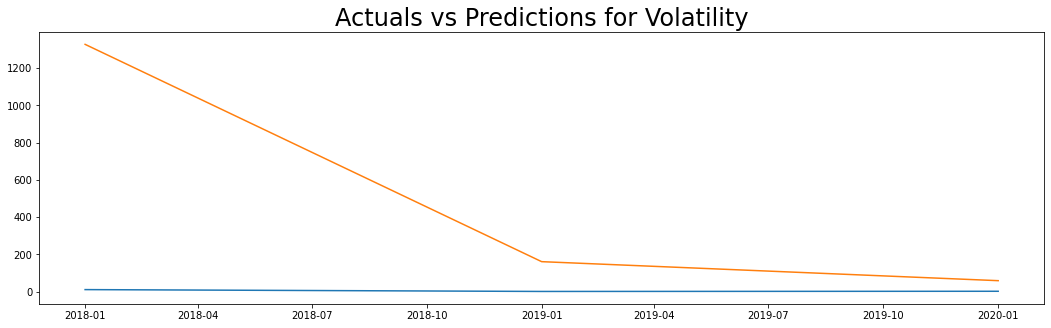

In [376]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df['vol'].abs())
plt.plot(predictions_df['Predictions'])

plt.title("Actuals vs Predictions for Volatility", size=24)

plt.show()

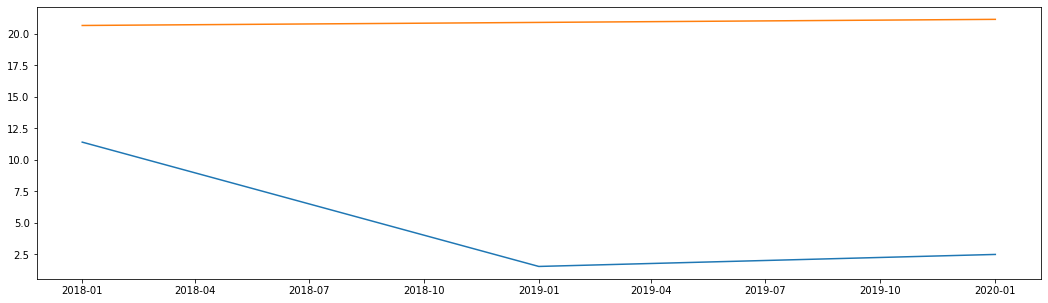

In [377]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data_vol.shape[0]))[
    : train_df_vol.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data_vol.shape[0]))[
    train_df_vol.shape[0] +1 :
].fillna(0)
y_train = train_df_vol["vol"].fillna(0)
y_test = test_df_vol["vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

Вывод: GARCH модели не удалось уловить тренд изменения дисперсии. Вероятная причина - слишком малая выборка. Линейная регрессия показала более приемлемые результаты.